In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.dates import MonthLocator, DayLocator

In [3]:
time_line = pd.read_excel('data/time_line.xlsx')
train = pd.read_csv('data/train.csv', index_col=0)
test = pd.read_csv('data/test.csv', index_col=0)

train['train'] = 1
test['train'] = 0

case = pd.read_excel('temp/number1.xlsx')
RI = pd.read_excel('temp/number2.xlsx')

ml_train = pd.read_csv('result/ml_train_results.csv', index_col=0)
ml_test = pd.read_csv('result/ml_test_results.csv',  index_col=0)
ml_data = pd.concat([ml_train,ml_test])


data = pd.concat([train,test])
result_data = pd.concat([data,ml_data[['svm','rf','xgb']]],axis=1)
result_data.sort_values('data_num',inplace=True)
result_data.reset_index(drop=True, inplace=True)
result_data = pd.concat([result_data,RI], axis=1)

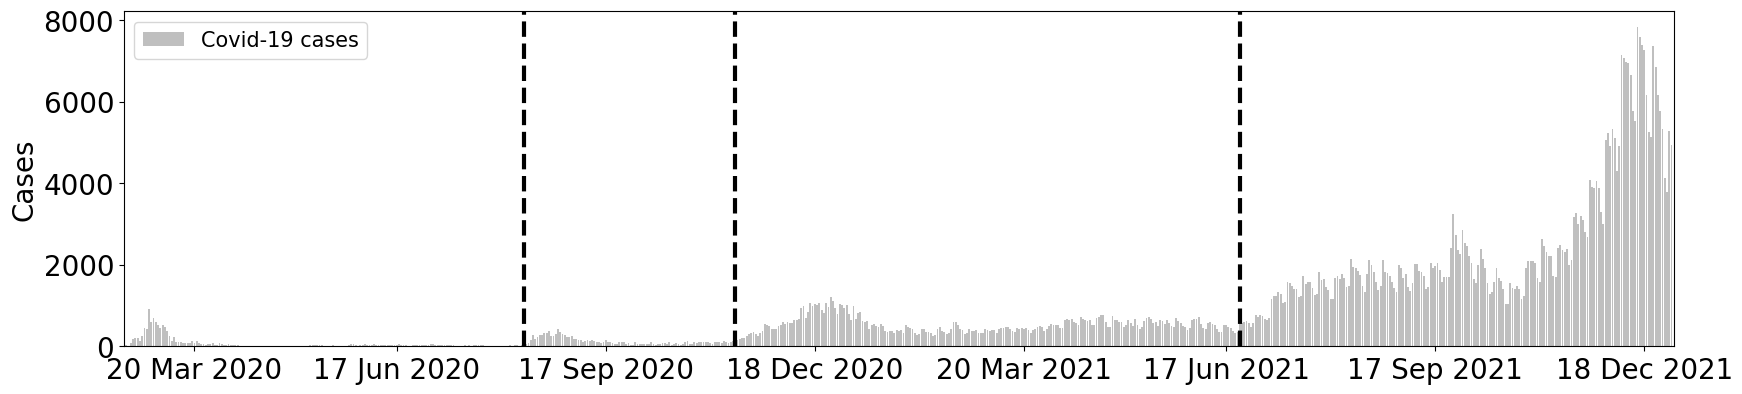

In [13]:
plt.figure(figsize=(20,10))
grid_s = gridspec.GridSpec(2,1)
plt.subplots_adjust(wspace=0.3, hspace=0.3)


x=range(len(case[0:682]))
y=case[0:682]['number']

ax = plt.subplot(grid_s[0])
plt.bar(x,y,color='gray',alpha=0.5, label='Covid-19 cases')
for i in range(3):
    if i==0:
        plt.axvline(time_line['start_time'][i],color='k',linestyle='--',linewidth=3)
    else:
        plt.axvline(time_line['start_time'][i],color='k',linestyle='--',linewidth=3)


plt.xlim([-0.1, 682])

#x축 날짜로 변경하기
xlabels = case[0:682].date.dt.strftime('%d %b %Y').to_list()
plt.xticks(case[0:682].idx, xlabels)
ax.xaxis.set_major_locator(MonthLocator(interval=3))


plt.xlim([-0.1, 682])
plt.ylabel('Cases')
plt.legend()
plt.show()

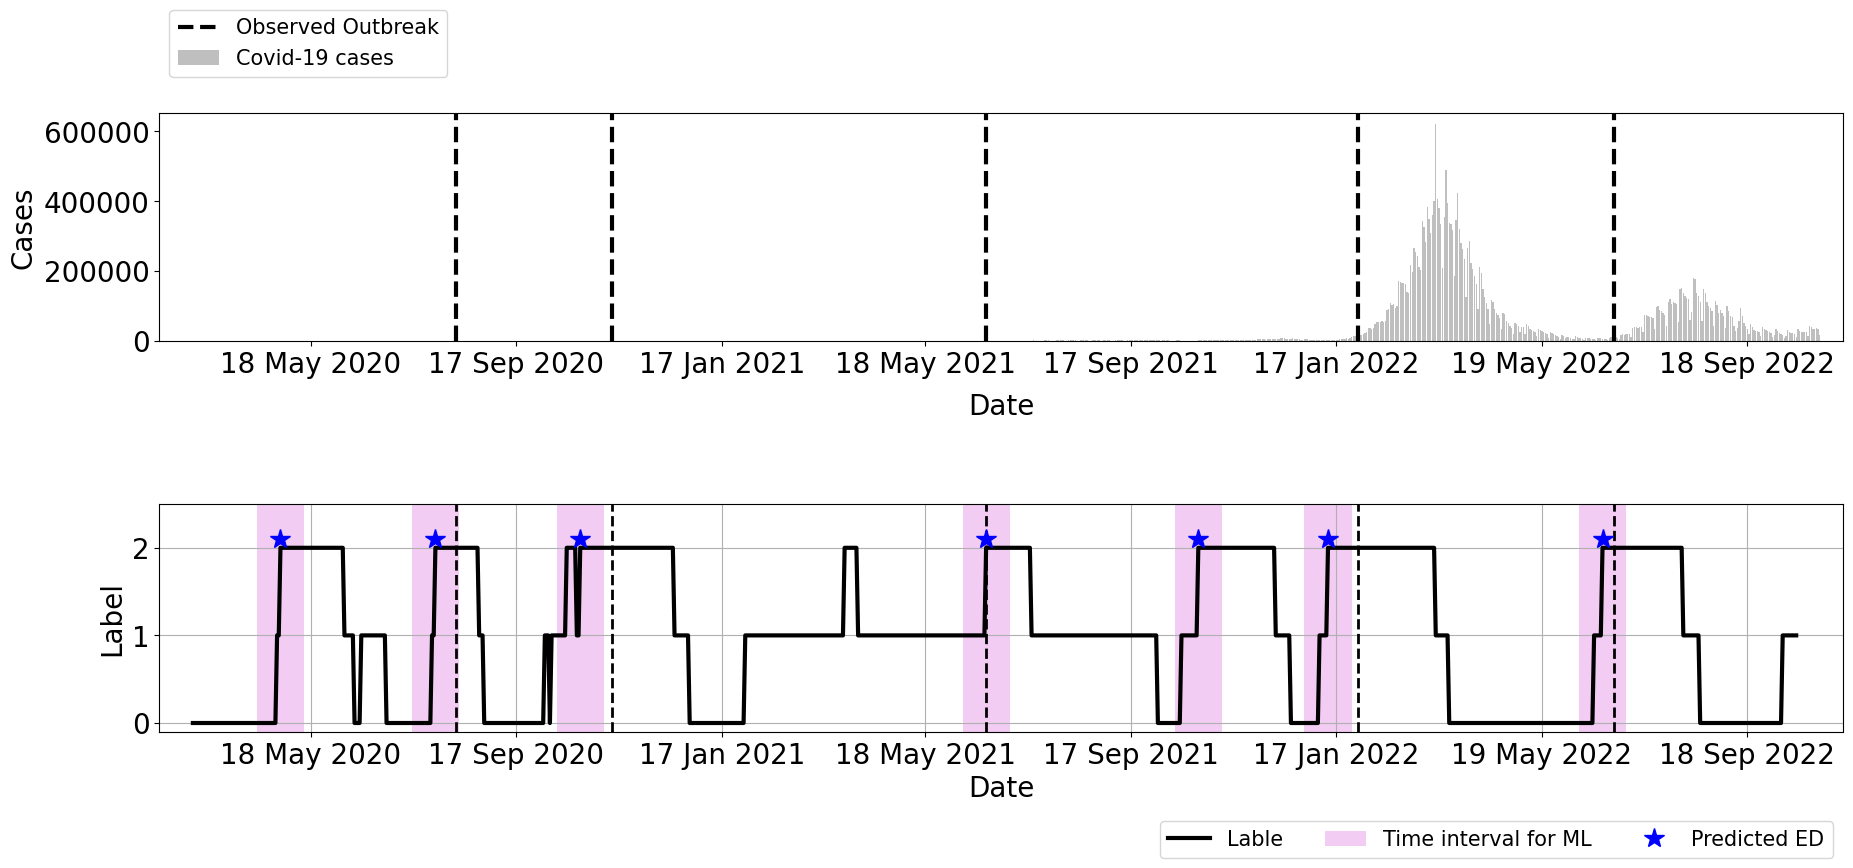

In [18]:
machine_method = ['svm', 'rf', 'xgb']
result_prob = pd.DataFrame()
early_time = []
lot = 0
sub_num = 20
time_interval = 14

row_start = []
row_end = []
for i in range(len(result_data)):
    if result_data.loc[i,'label']==2:
        if result_data.loc[i-1,'label']!=2:
            row_start.append(result_data.index[i])


            
for i in range(len(result_data)-1):
    if result_data.loc[i+1,'label']!=2:
        if result_data.loc[i,'label']==2:
            row_end.append(result_data.index[i])
            
row_start.append(result_data[result_data['label']==2].tail(1).index[0])


row_2=[]
for i in range(len(row_start)-1):
    if row_start[i+1]-row_start[i]>14:
        if row_end[i]-row_start[i]>14:
            row_2.append(row_start[i])

plt.rc('font', size=20)        
plt.rc('axes', labelsize=20)  
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20)  
plt.rc('legend', fontsize=15)  
plt.rc('figure', titlesize=50)

plt.figure(figsize=(20,10))
grid_s = gridspec.GridSpec(2,1)
plt.subplots_adjust(wspace=0.3, hspace=0.5)


x=range(len(case))
y=case['number']

ax = plt.subplot(grid_s[0])
plt.bar(x,y,color='gray',alpha=0.5, label='Covid-19 cases')
for i in range(5):
    if i==0:
        plt.axvline(time_line['start_time'][i],color='k',linestyle='--',linewidth=3, label='Observed Outbreak')
    else:
        plt.axvline(time_line['start_time'][i],color='k',linestyle='--',linewidth=3)


plt.xlim([-0.1, 1000])

#x축 날짜로 변경하기
xlabels = case.date.dt.strftime('%d %b %Y').to_list()
plt.xticks(case.idx, xlabels)
#plt.xticks(rotation=90)
ax.xaxis.set_major_locator(MonthLocator(interval=4))

plt.xlabel('Date',labelpad=10)
plt.ylabel('Cases')
plt.legend(loc='upper left', bbox_to_anchor=(0, 1.5))
#plt.legend()




ax = plt.subplot(grid_s[1])
plt.plot(result_data['data_num']+sub_num,result_data['label'],color='k',linewidth=3, label='Lable')

for i in range(5):
    plt.axvline(time_line['start_time'][i],color='k',linestyle='--',linewidth=2)
    
for i in range(len(row_2)):
    
    temp_start = row_2[i]+sub_num-time_interval
    temp_end = row_2[i]+sub_num+time_interval
    
    result_prob.loc[lot,'season'] = str(i+1)
    
    temp_train = result_data[(result_data['data_num']>=temp_start-sub_num) & (result_data['data_num']<=temp_end-sub_num) & (result_data['train']==1)]
    temp_test = result_data[(result_data['data_num']>=temp_start-sub_num) & (result_data['data_num']<=temp_end-sub_num) & (result_data['train']==0)]
        
    result_prob.loc[lot,'train_num'] = len(temp_train)
    result_prob.loc[lot,'test_num'] = len(temp_test)
    
    result_prob.loc[lot,'TT_rate'] = len(temp_test)/(len(temp_train)+len(temp_test))
    
    
    if i==1:
        plt.axvspan(temp_start,temp_end,facecolor='m',alpha=0.2, label='Time interval for ML')
    else:
        plt.axvspan(temp_start,temp_end,facecolor='m',alpha=0.2)
    for j in machine_method:
        
        result_prob.loc[lot,j+'_train']=len(temp_train[temp_train['label']==temp_train[j]])/len(temp_train)
        result_prob.loc[lot,j+'_test']=len(temp_test[temp_test['label']==temp_test[j]])/len(temp_test)
    early_time.append(temp_test[(temp_test['label']==2) & (temp_test['label']==temp_test['rf'])]['data_num'].values[0]+sub_num)    
        
    lot = lot+1
    
plt.plot(row_2+sub_num*np.ones(len(row_2)),2.1*np.ones(len(row_2)),'*',color='b',markersize=15, label='Predicted ED')


#x축 날짜로 변경하기
xlabels = case.date.dt.strftime('%d %b %Y').to_list()
plt.xticks(case.idx, xlabels)
#plt.xticks(rotation=90)
ax.xaxis.set_major_locator(MonthLocator(interval=4))


plt.xlim([-0.1, 1000])
plt.ylim([-0.1, 2.5])
plt.yticks([0, 1, 2])

#x축 날짜로 변경하기
xlabels = case.date.dt.strftime('%d %b %Y').to_list()
plt.xticks(case.idx, xlabels)
#plt.xticks(rotation=90)
ax.xaxis.set_major_locator(MonthLocator(interval=4))



plt.xlabel('Date')
plt.ylabel('Label')
plt.tight_layout(pad=3)
plt.grid(True)
# plt.legend(loc='upper right')
plt.legend(loc='lower right', ncol=3, bbox_to_anchor=(1, -0.6))


plt.show()

In [41]:
row_start_svm = []
row_end_svm = []
for i in range(len(result_data)):
    if result_data.loc[i,'svm']==2:
        if result_data.loc[i-1,'svm']!=2:
            row_start_svm.append(result_data.index[i])
            
for i in range(len(result_data)-1):
    if result_data.loc[i+1,'svm']!=2:
        if result_data.loc[i,'svm']==2:
            row_end_svm.append(result_data.index[i])
            
row_start_svm.append(result_data[result_data['svm']==2].tail(1).index[0])

row_2_svm=[]
for i in range(len(row_start_svm)-1):
    if row_start_svm[i+1]-row_start_svm[i]>14:
        if row_end_svm[i]-row_start_svm[i]>14:
            row_2_svm.append(row_start_svm[i])


row_start_rf = []
row_end_rf = []
for i in range(len(result_data)):
    if result_data.loc[i,'rf']==2:
        if result_data.loc[i-1,'rf']!=2:
            row_start_rf.append(result_data.index[i])
            
for i in range(len(result_data)-1):
    if result_data.loc[i+1,'rf']!=2:
        if result_data.loc[i,'rf']==2:
            row_end_rf.append(result_data.index[i])
            
row_start_rf.append(result_data[result_data['rf']==2].tail(1).index[0])

row_2_rf=[]
for i in range(len(row_start_rf)-1):
    if row_start_rf[i+1]-row_start_rf[i]>14:
        if row_end_rf[i]-row_start_rf[i]>14:
            row_2_rf.append(row_start_rf[i])

row_start_xgb = []
row_end_xgb = []
for i in range(1,len(result_data)):
    if result_data.loc[i,'xgb']==2:
        if result_data.loc[i-1,'xgb']!=2:
            row_start_xgb.append(result_data.index[i])
            
for i in range(1,len(result_data)-1):
    if result_data.loc[i+1,'xgb']!=2:
        if result_data.loc[i,'xgb']==2:
            row_end_xgb.append(result_data.index[i])
            
row_start_xgb.append(result_data[result_data['xgb']==2].tail(1).index[0])

row_2_xgb=[]
for i in range(len(row_start_xgb)-1):
    if row_start_xgb[i+1]-row_start_xgb[i]>14:
        if row_end_xgb[i]-row_start_xgb[i]>14:
            row_2_xgb.append(row_start_xgb[i])

/var/folders/vm/3m9x_kpn2v39f_fnjwhrws940000gn/T/ipykernel_56284/3954563364.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])


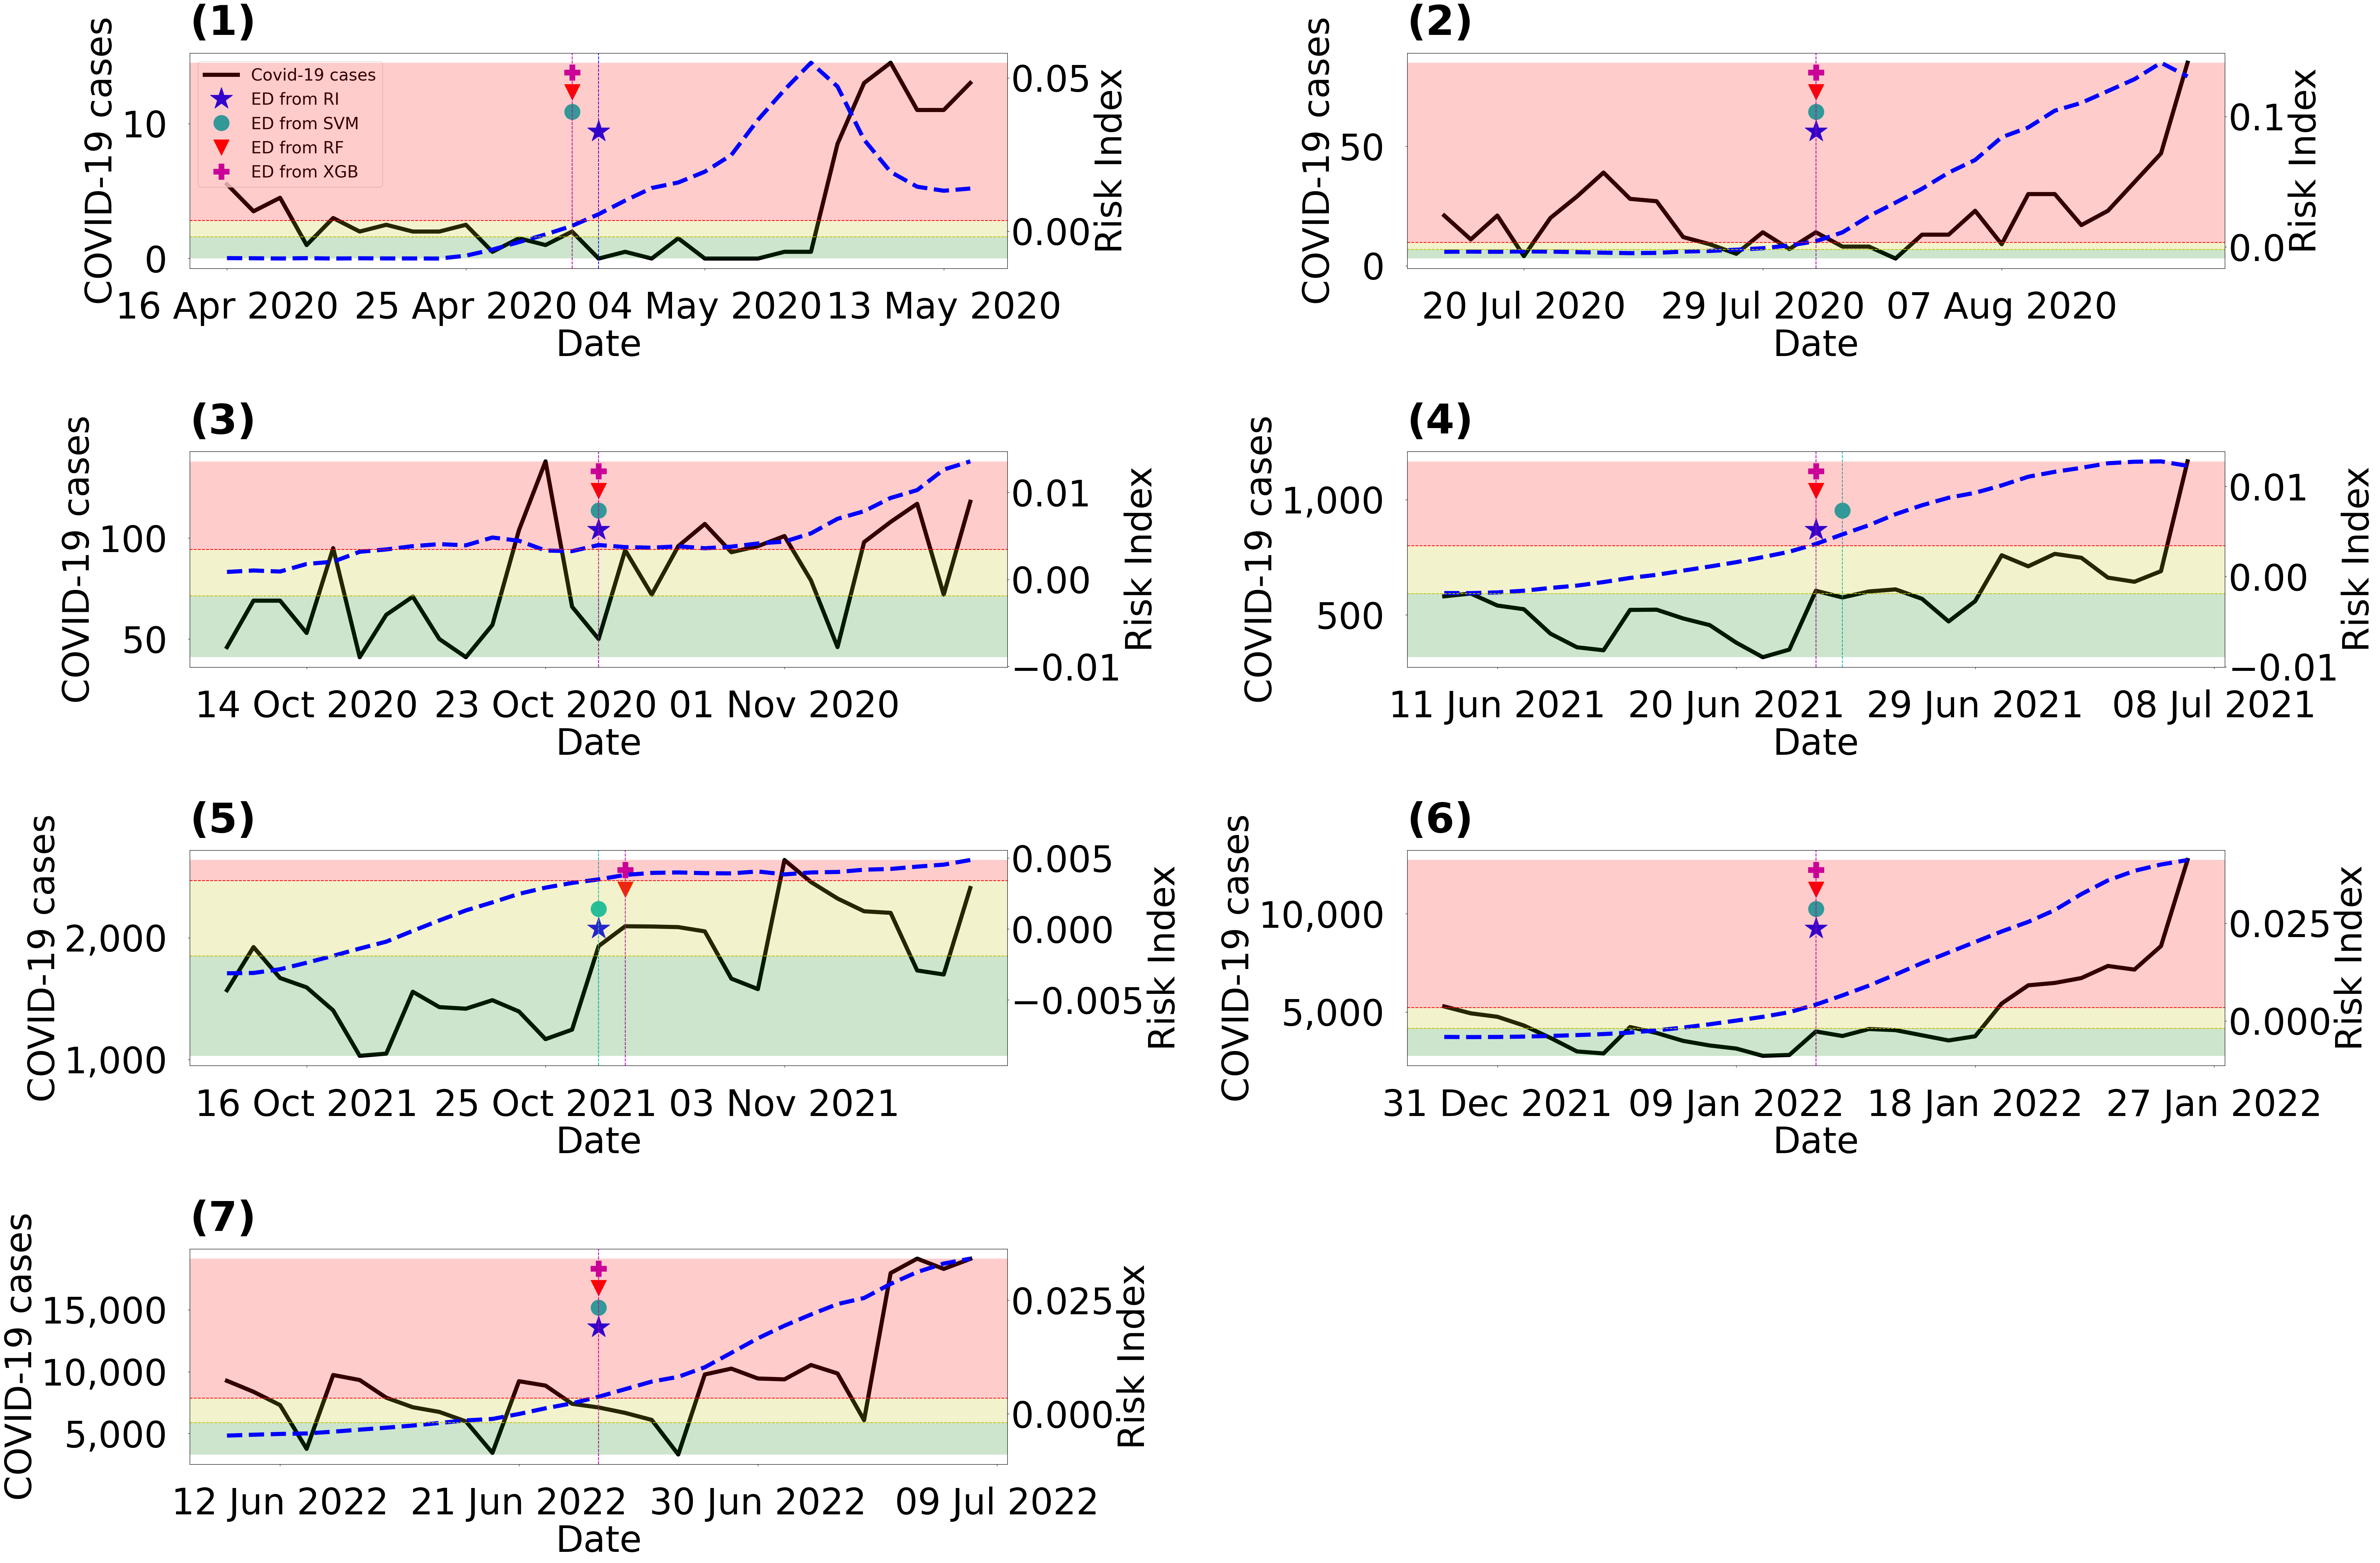

In [52]:
plt.rc('font', size=70)        
plt.rc('axes', labelsize=70)  
plt.rc('xtick', labelsize=70) 
plt.rc('ytick', labelsize=70)  
plt.rc('legend', fontsize=32)  


label2_line = result_data.loc[result_data['label']==2,'RI'].min()
label1_line = result_data.loc[result_data['label']==1,'RI'].min()
label0_line = result_data.loc[result_data['label']==0,'RI'].min()

plt.figure(figsize=(66,44))
grid_s = gridspec.GridSpec(4,2)

plt.subplots_adjust(wspace=0, hspace=0)

ax0= plt.subplot(grid_s[0])
ax0.set_title("(1)", loc="left", fontsize=80, fontweight="bold", pad=35)
ax1= plt.subplot(grid_s[1])
ax1.set_title("(2)", loc="left", fontsize=80, fontweight="bold", pad=35)
ax2= plt.subplot(grid_s[2])
ax2.set_title("(3)", loc="left", fontsize=80, fontweight="bold", pad=35)
ax3= plt.subplot(grid_s[3])
ax3.set_title("(4)", loc="left", fontsize=80, fontweight="bold", pad=35)
ax4= plt.subplot(grid_s[4])
ax4.set_title("(5)", loc="left", fontsize=80,fontweight="bold", pad=35)
ax5= plt.subplot(grid_s[5])
ax5.set_title("(6)", loc="left", fontsize=80,fontweight="bold", pad=35)
ax6= plt.subplot(grid_s[6])
ax6.set_title("(7)", loc="left",fontsize=80, fontweight="bold", pad=35)


for i in range(len(row_2)):
    ax = plt.subplot(grid_s[i])
    temp_start = row_2[i]+sub_num-time_interval
    temp_end = row_2[i]+sub_num+time_interval
    
    ax.plot(range(temp_start,temp_end+1), case.loc[temp_start:temp_end,'number'],'k',linewidth=8,label='Covid-19 cases')

    
    temp_y1 = case.loc[temp_start:temp_end,'number'].min()+0.65*(case.loc[temp_start:temp_end,'number'].max()-case.loc[temp_start:temp_end,'number'].min())
    temp_y2 = case.loc[temp_start:temp_end,'number'].min()+0.75*(case.loc[temp_start:temp_end,'number'].max()-case.loc[temp_start:temp_end,'number'].min())
    temp_y3 = case.loc[temp_start:temp_end,'number'].min()+0.85*(case.loc[temp_start:temp_end,'number'].max()-case.loc[temp_start:temp_end,'number'].min())
    temp_y4 = case.loc[temp_start:temp_end,'number'].min()+0.95*(case.loc[temp_start:temp_end,'number'].max()-case.loc[temp_start:temp_end,'number'].min())
    
    ax.plot(row_2[i]+sub_num,temp_y1,'*',color='b',markersize=45, label='ED from RI')
    ax.plot(row_2_svm[i]+sub_num,temp_y2,'o',color='c',markersize=30, label='ED from SVM')
    ax.plot(row_2_rf[i]+sub_num,temp_y3,'v',color='r',markersize=30, label='ED from RF')
    ax.plot(row_2_xgb[i]+sub_num,temp_y4,'P',color='m',markersize=30, label='ED from XGB')
    
    ax.axvline(row_2[i]+sub_num,color='b',linestyle='--',linewidth=1.5)
    ax.axvline(row_2_svm[i]+sub_num,color='c',linestyle='--',linewidth=1.5)
    ax.axvline(row_2_rf[i]+sub_num,color='r',linestyle='--',linewidth=1.5)
    ax.axvline(row_2_xgb[i]+sub_num,color='m',linestyle='--',linewidth=1.5)    
    
    
    ax.set_xlabel('Date') 
    ax.set_ylabel('COVID-19 cases')

    ax.tick_params(pad=40)
    xlabels = case.date.dt.strftime('%d %b %Y').to_list()
    plt.xticks(case.idx, xlabels)
    ax.xaxis.set_major_locator(DayLocator(interval=9))
    
    current_values = plt.gca().get_yticks()  
    ax.set_yticklabels(['{:,.0f}'.format(x) for x in current_values])
    

    
    
    ax2 = ax.twinx()
    ax2.plot(range(temp_start,temp_end+1), result_data.loc[temp_start-sub_num:temp_end-sub_num,'RI'],'--b',linewidth=8,label='RI')
    ax2.axhline(label2_line,color='r',linestyle='--',linewidth=1.5,label='Label 2')
    ax2.axhline(label1_line,color='y',linestyle='--',linewidth=1.5,label='Label 1')
    
    
    ax2.axhspan(label0_line,label1_line,facecolor='g',alpha=0.2)
    ax2.axhspan(label1_line,label2_line,facecolor='y',alpha=0.2)
    ax2.axhspan(label2_line,result_data.loc[temp_start-sub_num:temp_end-sub_num,'RI'].max(),facecolor='r',alpha=0.2)
    
    ax2.set_ylabel('Risk Index', fontsize=70)
    if i==0:
        ax.legend(loc='upper left', bbox_to_anchor=(0, 1.0))
    
    plt.tight_layout()
plt.show()